In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.text import *
from fastai.vision import *
from fastai.utils.mem import *
from fastai.tabular import *
import scipy.signal as s
import pyts
from itertools import chain 

In [3]:
path = Path("data/LFP_Prediction")

In [4]:
labels = pd.read_csv(path/"lfp_labels_new_data.csv", index_col = "start")

In [5]:
df = pd.read_csv(path/"model_fr_lfp_new.csv")

In [6]:
df = df.iloc[:len(labels)]

In [7]:
df["avgPNA"] = np.array([df.PNA1, df.PNA2, df.PNA3, df.PNA4, df.PNA5]).mean(0)

In [8]:
df["avgPNC"] = np.array([df.PNC1, df.PNC2, df.PNC3, df.PNC4, df.PNC5]).mean(0)

In [9]:
df["avgITN"] = np.array([df.ITN1, df.ITN2, df.ITN3, df.ITN4, df.ITN5]).mean(0)

In [10]:
class TimeWindow(ItemBase):
    def __init__(self, time_window):
        time_window = np.copy(time_window)
        self.obj = (time_window)
        self.data = torch.Tensor(time_window)
        self.data = self.data[None]
        
    def to_one(self): return self.data
    
    def apply_tfms(self, tfms, **kwargs):
        return
    
    def __repr__(self):
        return "A time points plus"

In [11]:
class TimeWindowList(ItemList):
    _label_cls = CategoryList
    def __init__(self, items, num_back, num_forward, data_input, **kwargs):
        self.its = items
        super().__init__(items, **kwargs)
        self.num_forward = num_forward
        self.num_back = num_back
        self.data_input = data_input
        self.copy_new.append("data_input")
        self.copy_new.append("num_back")
        self.copy_new.append("num_forward")
        
    def get(self, i):
        i = self.items[i]
        return TimeWindow(self.data_input[i - self.num_back : i, :-1])
    
    def reconstruct(self, t:Tensor):
        return TimeWindow(t)
    
    def __len__(self):
        return len(self.items)
    
    def label_from_func(self, func:Callable, label_cls:Callable=None, **kwargs)->'LabelList':
        "Apply `func` to every input to get its label."
        return self._label_from_list([self.label_func(o) for o in range(0, len(self))], label_cls=label_cls, **kwargs)
    
    def label_func(self, i):
        #return torch.Tensor(int(1 in self.its[i + self.num_back: i + self.num_back + self.num_forward, 3]))[None]
        return int(self.data_input[self.items[i], -1] >= 2)

In [12]:
num_back = 40
num_forward = 10

In [13]:
columns = df.columns
columns

Index(['PNA1', 'PNA2', 'PNA3', 'PNA4', 'PNA5', 'PNC1', 'PNC2', 'PNC3', 'PNC4',
       'PNC5', 'ITN1', 'ITN2', 'ITN3', 'ITN4', 'ITN5', 'rawLFP', 'filtLFP',
       'hilbLFP', 'avgPNA', 'avgPNC', 'avgITN'],
      dtype='object')

In [14]:
var_names = [columns[15]] + [columns[i] for i in range(-3, 0)]

In [15]:
var_names

['rawLFP', 'avgPNA', 'avgPNC', 'avgITN']

In [16]:
data_input = np.stack([df[columns[15]]] + [df[columns[i]] for i in range(-3, 0)] + [labels.next_peak], axis = -1)

In [17]:
data_input.shape

(199300, 5)

In [18]:
indexes = [i for i in range(num_back, len(data_input)) if labels.time_until_peak[i] <= 3 and labels.time_until_peak[i] >= 1]

In [19]:
len(indexes)

39558

In [20]:
#Replicating each true sample once
index = 0
while(index < len(indexes)):
    if index >= 10000 and data_input[indexes[index]][-1] >= 2:
        indexes = np.insert(indexes, index, indexes[index], axis = 0)
        index += 1
    index += 1

In [21]:
len(indexes)

43512

In [22]:
data = (TimeWindowList(indexes, num_back, num_forward, data_input)
                .split_by_idx(range(10000))
                .label_from_func(lambda x: x)
                .databunch(bs = 64, num_workers = 0))

In [23]:
data

DataBunch;

Train: LabelList (33512 items)
x: TimeWindowList
A time points plus,A time points plus,A time points plus,A time points plus,A time points plus
y: CategoryList
0,0,0,0,0
Path: .;

Valid: LabelList (10000 items)
x: TimeWindowList
A time points plus,A time points plus,A time points plus,A time points plus,A time points plus
y: CategoryList
0,0,0,1,1
Path: .;

Test: None

In [24]:
class myAttention(nn.Module):
    def __init__(self, in_features, in_len):
        super().__init__()
        self.in_features = in_features
        self.in_len = in_len
        self.weight = torch.nn.Parameter(torch.Tensor(in_features, in_len))
        
        self.reset_parameters()
        
    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
            
    def forward(self, input):
        return input * self.weight

In [25]:
class PaperModel(nn.Module):
    def __init__(self, out_size, num_features):
        super().__init__()
        self.num_features = num_features
        self.convs_2d = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size = (9, 1), padding = (4, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size = (7, 1), stride = (2, 1), padding = (3, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.25),
            nn.Conv2d(128, 1, kernel_size = (1,1)),
            nn.ReLU(),
            nn.BatchNorm2d(1),
            nn.Dropout(0.4),
        )
        self.convs_1d = nn.Sequential(
            nn.Conv1d(num_features, 64, kernel_size = (5), padding = (2)),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.4),
            nn.Conv1d(64, 128, kernel_size = (5), stride = 2, padding = (2)),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),
            #myAttention(128, 10)
            #Add element-wise attention multiplication here
            #nn.AdaptiveAvgPool1d(output_size=1)
            #nn.AvgPool1d(10)
        )
        self.lins = nn.Sequential(
            nn.Linear(1280, 640),
            nn.ReLU(),
            nn.BatchNorm1d(640),
            nn.Dropout(),
            nn.Linear(640, 320),
            nn.ReLU(),
            nn.BatchNorm1d(320),
            nn.Dropout(),
            nn.Linear(320, 160),
            nn.ReLU(),
            nn.BatchNorm1d(160),
            nn.Dropout(),
            nn.Linear(160, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(),
            nn.Linear(32, out_size),
        )
        
    def forward(self, x):
        x = self.convs_2d(x)
        x = torch.squeeze(x, dim = 1)
        x = torch.transpose(x, 1, 2)
        x = self.convs_1d(x)
        x = torch.flatten(x, start_dim = 1)
        #x = torch.squeeze(x, dim = 2)
        x = self.lins(x)
        return x

In [26]:
def isNan(num):
    return num != num

In [27]:
def true_acc(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    mask = targs == 1
    acc = float((input[mask]==targs[mask]).float().mean())
    if isNan(acc):
        return torch.Tensor([0.0]).cuda().mean()
    else:
        return (input[mask]==targs[mask]).float().mean()

In [28]:
def false_acc(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    mask = targs == 0
    acc = float((input[mask]==targs[mask]).float().mean())
    if isNan(acc):
        return torch.Tensor([0.0]).cuda().mean()
    else:
        return (input[mask]==targs[mask]).float().mean()

In [29]:
learn = Learner(data, PaperModel(2, 4), loss_func = torch.nn.modules.loss.CrossEntropyLoss(weight = torch.Tensor([1, 2]).cuda()), 
            metrics = [accuracy, true_acc, false_acc], wd = 1e-4)

In [250]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


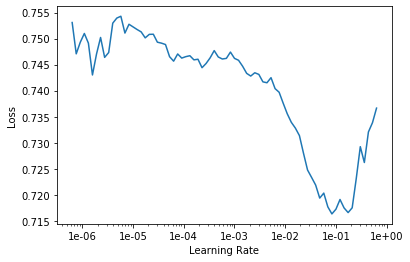

In [251]:
learn.recorder.plot(skip_end = 10)

In [252]:
lr = 1e-2

In [32]:
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,time
0,0.542307,0.488792,0.771800,0.558059,0.797237,00:27
1,0.501701,0.476103,0.816200,0.471373,0.892696,00:26
2,0.491694,0.451318,0.784400,0.657905,0.786954,00:26
3,0.473379,0.443610,0.811800,0.539385,0.860880,00:25
4,0.457197,0.438787,0.808300,0.577322,0.843833,00:25


## Results

In [31]:
interp = ClassificationInterpretation.from_learner(learn, ds_type = DatasetType.Valid)

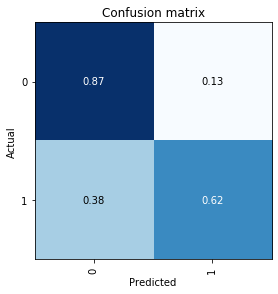

In [32]:
interp.plot_confusion_matrix(normalize = True)

# Explanation

In [33]:
from fastai.callbacks.hooks import *

In [34]:
m = learn.model.eval()

In [35]:
m

PaperModel(
  (convs_2d): Sequential(
    (0): Conv2d(1, 64, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25)
    (4): Conv2d(64, 128, kernel_size=(7, 1), stride=(2, 1), padding=(3, 0))
    (5): ReLU()
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25)
    (8): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4)
  )
  (convs_1d): Sequential(
    (0): Conv1d(4, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4)
    (4): Conv1d(64, 128, kernel_size=(5,), stride=(2,), padding=(2,))
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1

# Features

In [40]:
sm = nn.Softmax(1)
relu = nn.ReLU()

In [47]:
#Insert k into arr every N elements.
#Used to deal with strides in convolutional layers.
def insert(arr, k, N):
    res = list(chain(*[arr[i : i+N] + [k]  
            if len(arr[i : i+N]) == N  
            else arr[i : i+N]  
            for i in range(0, len(arr), N)]))
    return res

#Take an array with ones and zeros and determines what more will be effected by a kernel of the given size.
#Used to find what part of the input is impacting an activation.
def add_kernel(arr, size):
    dist = size // 2
    picked = np.where(arr == 1)[0]
    for i in picked:
        for j in range(i - dist, i + dist + 1):
            if j >= 0 and j < len(arr):
                arr[j] = 1
                
    return arr

#Assumes all kernel sizes are odd and that the dimensions of the activations are even at every layer.
#Goes througha given model and returns what part of the input impacted a certain activation.
def get_touched(cur, seq, start):
    current = cur.copy()
    for i in range(start+1):
        layer = seq[start - i]
        if str(layer)[:4] == "Conv":
            if layer.stride[0] != 1:
                current = current.T.tolist()
                for j in range(len(current)):
                    current[j] = insert(current[j], 0, layer.stride[0] - 1)
                current = np.array(current).T
            kernel_size = layer.kernel_size[0]
            current = current.T
            for j in range(len(current)):
                current[j] = add_kernel(current[j], kernel_size)
            current = current.T
    return current

#Takes a vector and turns it into a matrix that is a repeat of the given vector.
def make_2d(current):
    return np.repeat(current, 4, axis = 1)

#Goes througha given model and returns what part of the input impacted a certain activation.
#Used when the starting layer is a Conv1d.
def get_important(current, seq_1d, seq_2d, start):
    current = get_touched(current, seq_1d, start)
    current = make_2d(current)
    current = get_touched(current, seq_2d, len(seq_2d) - 1)
    
    return current

#Passes the given input through the model and returns the activation hook at the given layer.
def hooked_acts(xb, layer):
    with hook_output(layer) as hook_a: 
        preds = m(xb)
    return hook_a

#Passes the given input through the model and returns the gradient of the activations at the given layer
#in respect to predicting the given category.
def hooked_grads(cat, xb, layer):
    with hook_output(layer, grad = True) as hook_g: 
        preds = m(xb)
        preds[0, int(cat)].backward()
    return hook_g

#Takes an input time series and a layer and determines at that layer how important each
#feature map is in classifying the input correctly.
def get_feature_imp(data, item, layer, m, y_actual = True, mean_twice = False):
    y = item[1]
    if not y_actual:
        y = get_pred(item)
    xb, _ = data.one_item(item[0])
    xb = xb.cuda()
    hook_g = hooked_grads(y, xb, layer)
    
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1)
    if mean_twice:
        grad_chan = grad_chan.mean(1)
        
    return np.array(grad_chan)

#Gets the importance of each feature at a certain layer for the entire validation set.
#Separates the importances by y value of the individual inputs.
def get_all_feat_imps(data, layer, m, y_actual = True, mean_twice = False):
    t_imps = []
    f_imps = []
    for item in data.valid_ds:
        if int(item[1]) == 1:
            t_imps.append(get_feature_imp(data, item, layer, m, y_actual = y_actual, mean_twice = mean_twice))
        else:
            f_imps.append(get_feature_imp(data, item, layer, m, y_actual = y_actual, mean_twice = mean_twice))
            
    return np.array(f_imps), np.array(t_imps)

#Passes the given input through the model and returns the activations at the given layer.
def get_activations(item, layer):
    xb, _ = data.one_item(item[0])
    xb = xb.cuda()
    h_a = hooked_acts(xb, layer)
    return h_a.stored[0].cpu()

#Takes an array and returns the indexes of the num number of highest values.
def get_max(arr, num):
    ind =  np.argpartition(arr, -num)[-num:]
    return ind[np.argsort(arr[ind])]

#Takes a feature map from a certain layer and returns what part of the input impacts the highest value in the given feature map.
#Used for when the feature map comes from a Conv2d.
def get_feat_max_2d(feat, item, seq, start):
    x = item[0].data[0]
    pos = feat.argmax()
    current = np.zeros(feat.shape)
    current[pos//feat.shape[1], pos%feat.shape[1]] = 1
    touched = get_touched(current, seq, start)
    return touched

#Takes a feature map from a certain layer and returns what part of the input impacts the highest value in the given feature map.
#Used for when the feature map comes from a Conv1d.
def get_feat_max_1d(feat, item, m, start):
    x = item[0].data[0]
    pos = feat.argmax()
    current = np.zeros((len(feat), 1))
    current[pos, 0] = 1
    touched = get_important(current, m.convs_1d, m.convs_2d, start)
    return touched

#Takes a feature map from a certain layer and returns the gradient of the input in terms of the highest activation in the given feature map.
#Used for when the feature map comes from a Conv1d.
def get_feat_max_1d_grad(feat, item, m, start):
    xb, _ = data.one_item(item[0])
    xb = xb.cuda()
    xb.requires_grad_()
    m.zero_grad()
    out = m.convs_2d(xb)
    out = torch.squeeze(out, dim = 1)
    out = torch.transpose(out, 1, 2)
    out = m.convs_1d[:start + 1](out)
    pos = out[0, feat, :].argmax()
    out[0, feat, pos].backward()
    guided = xb.grad.squeeze().cpu()
    m.zero_grad()
    
    return guided

In [46]:
f_imps, t_imps = get_all_feat_imps(data, m.convs_1d[4], m)

In [50]:
f_avg = f_imps.mean(0)

In [60]:
#Top 10 most important features for predicting false (least to most)
get_max(f_avg, 10)

array([ 91,  22,  54,  55,  21, 105, 102,   6,  90,   2], dtype=int64)

In [52]:
t_avg = t_imps.mean(0)

In [61]:
#Top 10 most important features for predicting true (least to most)
get_max(t_avg, 10)

array([12, 25, 87, 53, 49, 60, 45,  8, 42,  3], dtype=int64)

In [45]:
#Gets the highest activation of each feature for each validation item from the last convulotional layer.
#Also gets all of the activations for each item at that layer.
layer = m.convs_1d[4]
highest = []
all_acts = []
for item in data.valid_ds:
    acts = get_activations(item, layer)
    highest.append([feat.max() for feat in acts])
    all_acts.append(np.array(acts))
    
highest = np.array(highest)
all_acts = np.array(all_acts)

In [62]:
highest.shape

(10000, 128)

In [63]:
all_acts.shape

(10000, 128, 10)

In [85]:
feat_highs = [np.array(data.valid_ds[i][0].data[0]) for i in get_max(highest[:, 3], 10)]

In [86]:
toucheds = [get_feat_max_1d(all_acts[i, 3], data.valid_ds[i], m, 4) for i in get_max(highest[:, 3], 10)]

In [87]:
toucheds = np.array(toucheds)

In [88]:
feat_highs = np.array(feat_highs)

In [89]:
means = feat_highs.mean(0)

Can also look at mean

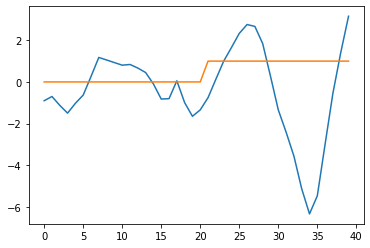

In [91]:
plt.plot(means[:, 0])
plt.plot(toucheds[0, :, 0])

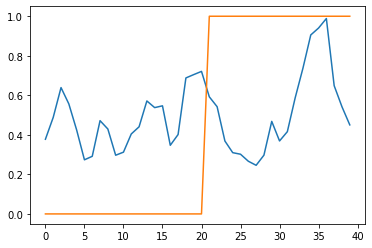

In [95]:
plt.plot(means[:, 1])
plt.plot(toucheds[0, :, 0])

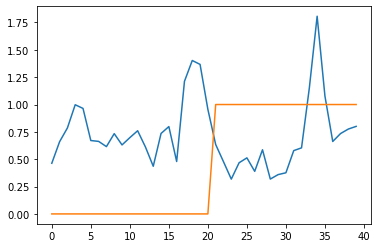

In [98]:
plt.plot(means[:, 2])
plt.plot(toucheds[0, :, 0])

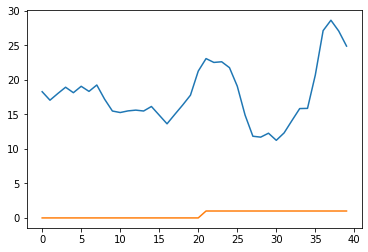

In [99]:
plt.plot(means[:, 3])
plt.plot(toucheds[0, :, 0])

rawLFP


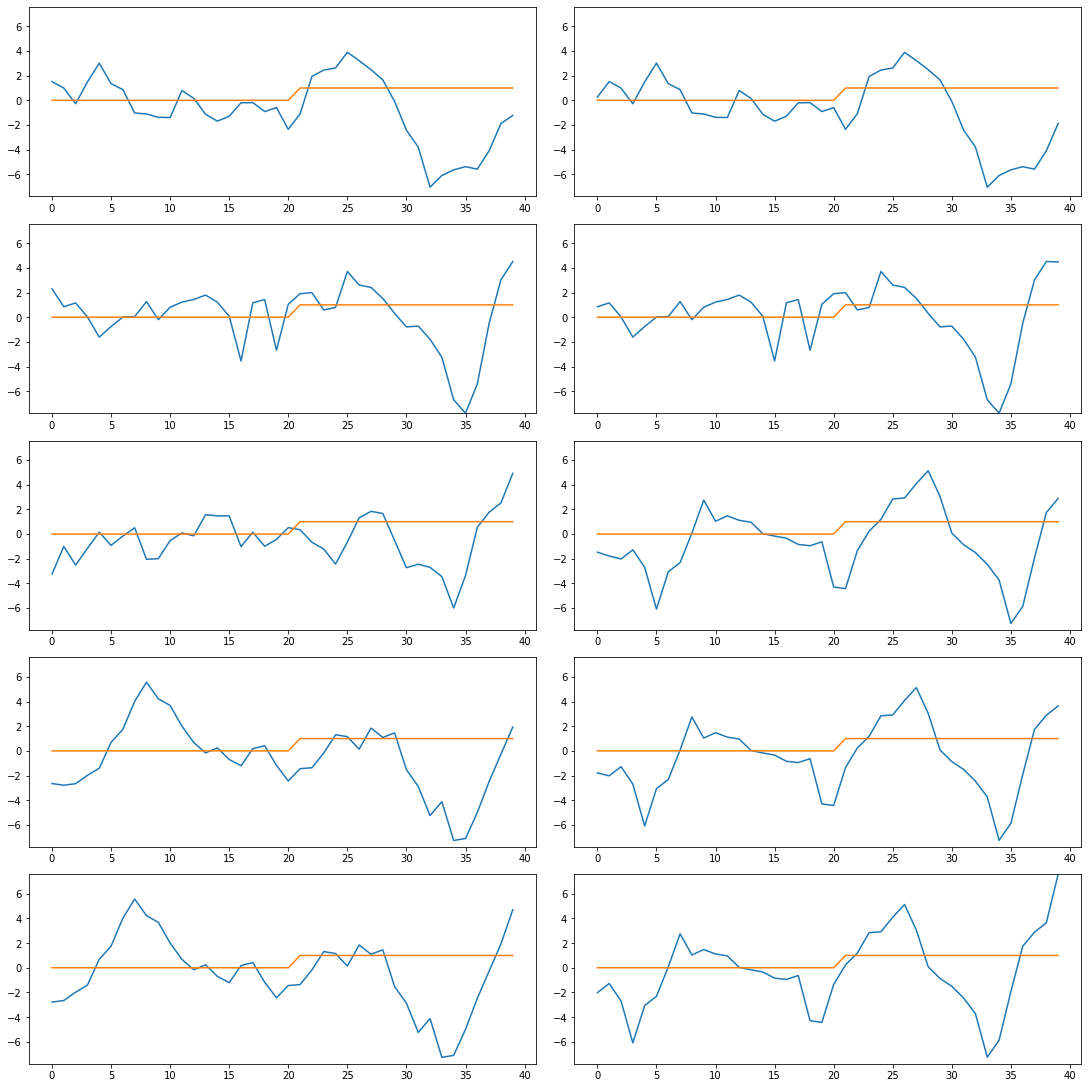

In [100]:
var = 0
print(var_names[var])
fig, axs = plt.subplots(5, 2, figsize=(15, 15), constrained_layout=True)
count = 0
extent = [0, 40, 0, 1]
for ax in axs.flat:
    ax.set_ylim([feat_highs[:, :, var].min(), feat_highs[:, :, var].max()])
    ax.plot(feat_highs[count, :, var])
    ax.plot(toucheds[count, :, var])
    count += 1
plt.show()
#plt.savefig(path/"results.pdf", format='pdf')

avgPNA


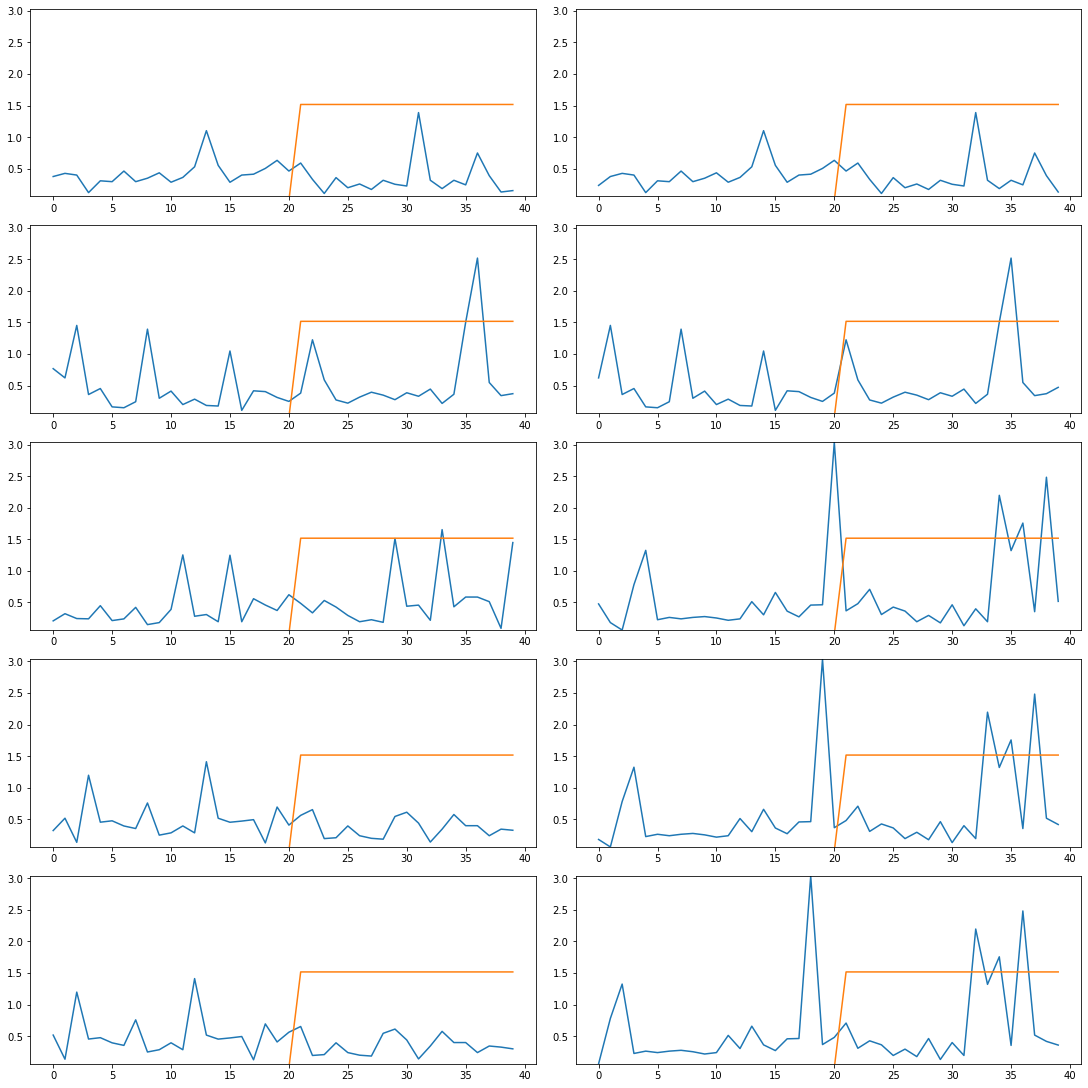

In [101]:
var = 1
print(var_names[var])
fig, axs = plt.subplots(5, 2, figsize=(15, 15), constrained_layout=True)
count = 0
extent = [0, 40, 0, 1]
for ax in axs.flat:
    ax.set_ylim([feat_highs[:, :, var].min(), feat_highs[:, :, var].max()])
    ax.plot(feat_highs[count, :, var])
    ax.plot(toucheds[count, :, var] * (feat_highs[:, :, var].max() / 2))
    count += 1
plt.show()
#plt.savefig(path/"results.pdf", format='pdf')

avgPNC


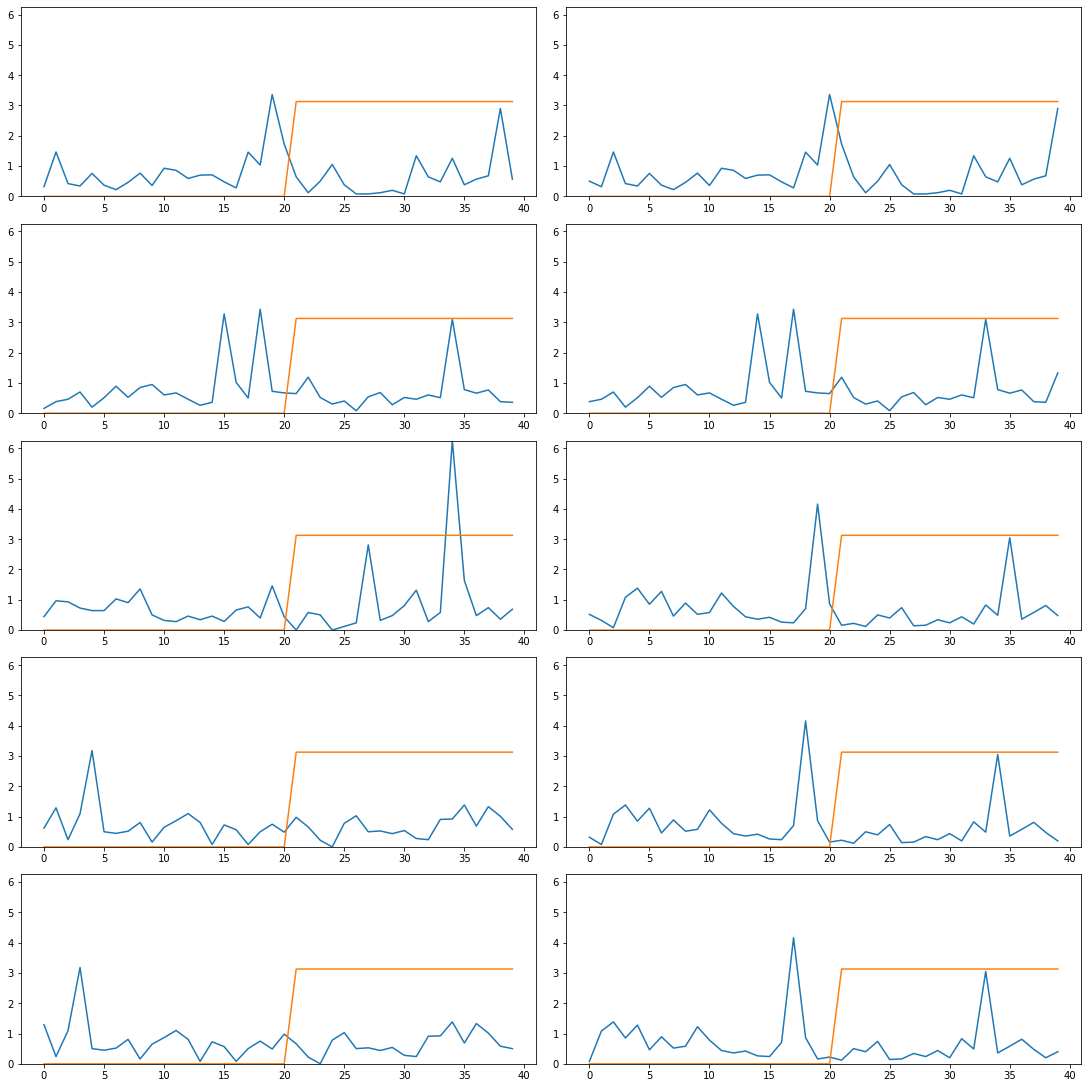

In [102]:
var = 2
print(var_names[var])
fig, axs = plt.subplots(5, 2, figsize=(15, 15), constrained_layout=True)
count = 0
extent = [0, 40, 0, 1]
for ax in axs.flat:
    ax.set_ylim([feat_highs[:, :, var].min(), feat_highs[:, :, var].max()])
    ax.plot(feat_highs[count, :, var])
    ax.plot(toucheds[count, :, var] * (feat_highs[:, :, var].max() / 2))
    count += 1
plt.show()
#plt.savefig(path/"results.pdf", format='pdf')

avgITN


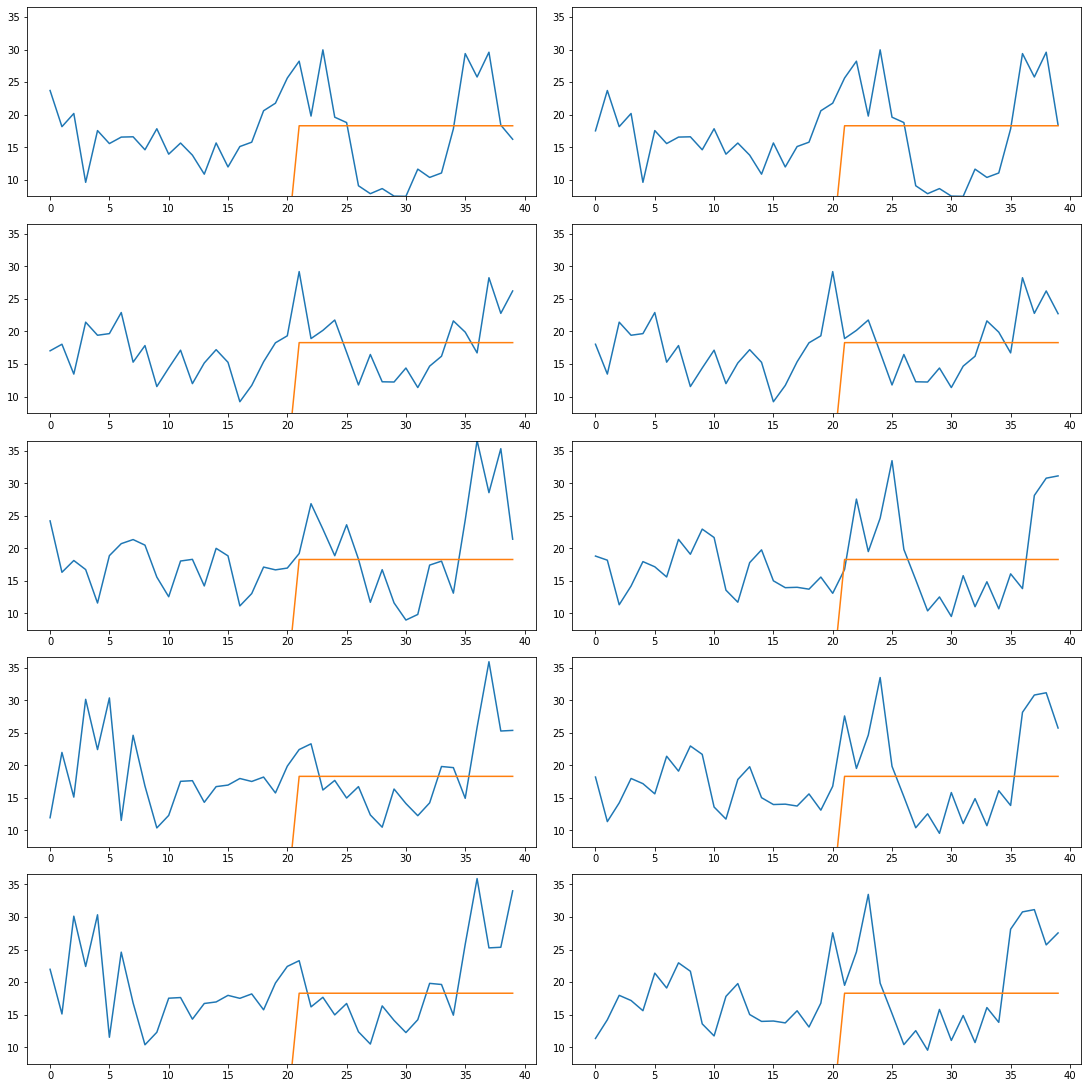

In [103]:
var = 3
print(var_names[var])
fig, axs = plt.subplots(5, 2, figsize=(15, 15), constrained_layout=True)
count = 0
extent = [0, 40, 0, 1]
for ax in axs.flat:
    ax.set_ylim([feat_highs[:, :, var].min(), feat_highs[:, :, var].max()])
    ax.plot(feat_highs[count, :, var])
    ax.plot(toucheds[count, :, var] * (feat_highs[:, :, var].max() / 2))
    count += 1
plt.show()
#plt.savefig(path/"results.pdf", format='pdf')

## Experimenting With Input Gradient Too

In [104]:
highest[:, 3].argmax()

785

In [105]:
item = data.valid_ds[785]

In [106]:
imp = get_feat_max_1d_grad(3, item, m, 4)

In [107]:
ind = 785
item = data.valid_ds[ind]
feat = all_acts[ind, 3]
touched = get_feat_max_1d(feat, item, m, 4)

x = item[0].data[0]

In [108]:
x.shape

torch.Size([40, 4])

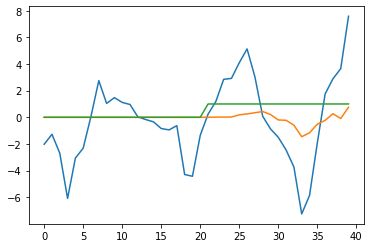

In [115]:
#Orange = gradient
#Blue = input
#Green = where important
plt.plot(x[:, 0])
plt.plot(imp[:, 0])
plt.plot(touched[:, 0])

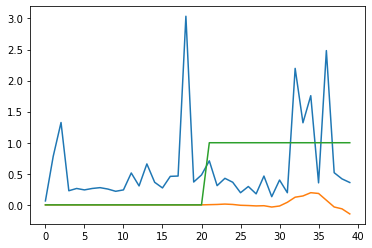

In [111]:
plt.plot(x[:, 1])
plt.plot(imp[:, 1])
plt.plot(touched[:, 1])

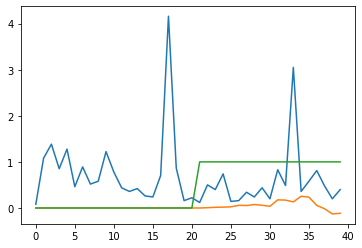

In [112]:
plt.plot(x[:, 2])
plt.plot(imp[:, 2])
plt.plot(touched[:, 2])

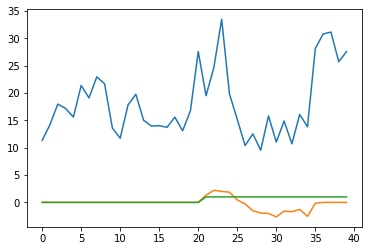

In [114]:
plt.plot(x[:, 3])
plt.plot(imp[:, 3] * 100)
plt.plot(touched[:, 3])